# Finding Weightings
In this section, we will try to find the optimal weightings with the stocks that have been chosen. We will be implementing ideas from Modern Portfolio Theory by using ideas from Ivanyuk and Berzin (2020). In the next section, we will go over the theory behind this model. Then, we will implement our ideas to create a portfolio that meets our needs.

In [64]:
# MOVE THIS TO THE TOP LATER
# LIBRARIES NEEDED
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, base_optimizer
from typing import Tuple, List

# MODULES
import jason
import patrick
import markowitz

In [65]:
# THIS WILL PROBABLY BE REMOVED
# This code block is to get stocks data
start_date = "2012-11-09"
end_date = "2024-11-09"
valid_stocks = jason.valid_stocks("Tickers_Example.csv")
close_prices = markowitz.getClosePrices(start_date, end_date, valid_stocks[:4], start_date)
display(close_prices.head())

$AGN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$MON: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$RTN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  4 of 4 completed


Ticker,ABT,ACN,AIG
Date,,,
2012-11-09,31.110231,65.809998,32.169998
2012-11-12,31.124626,66.639999,31.980000
2012-11-13,31.033464,66.279999,31.350000
2012-11-14,30.582453,65.050003,30.680000
2012-11-15,30.323360,64.589996,31.240000


## Explanation
The main assumption behind the Markowitz Model is that investors are willing to accept more risk if they get more returns. In other words, the best portfolio is the one that provides the most returns for the same amount of risk. 

Firstly, we will plot out a portfolio that assigns random weightings to random stocks. We plot the returns on a scatter graph.

Note that the following code is only an example and is not coded to be dynamic. We include a dynamic implementation in the section after.

The following functions will help simulate the randomly-weighted portfolio. The first function is to generate a list of weightings that add up to one. The second function will return a dataframe with those weightings applied. The third function gets the risk and returns of these random portfolios. The fourth function will plot it out.

In [66]:
def getRandomWeightings(length: int, min_weight: float = 0) -> List[float]:
    # Returns a list of random weightings
    # Requires that the min_weight * len <= 1
    weightings_lst = np.random.random(size=length)  # Find random weightings
    # Make sure weightings_lst sums up to weight remainder
    weightings_lst /= np.sum(weightings_lst)
    weightings_lst *= 1 - min_weight
    weightings_lst += min_weight
    return weightings_lst.tolist()
# Example:
print("Test random weightings:", getRandomWeightings(len(close_prices.columns), 0))


def applyWeightings(df: pd.DataFrame, weightings: list, investment: int) -> pd.DataFrame:
    # Returns the dataframe adjusted for all the weightings
    # Requires that df has the same number of rows as the length of weightings
    i = 0
    for column in df.columns.values:
        # find shares
        shares = investment / df[column].iloc[0]
        df[column] *= shares * weightings[i]
        i = i + 1
    return df
# Example
display(applyWeightings(close_prices, getRandomWeightings(len(close_prices.columns)), 1000000).head())


def simulateRandom(tests: int, stock_data: pd.DataFrame) -> Tuple[list, list, float, float]:
    # Simulates tests amount of tests with random weightings
    stocks_amount = len(stock_data.columns)
    results = [[], [], []]
    min_std = 1000  # We want to find the minimum and maximum standard deviations later
    max_std = -1000
    weighting_record = []
    for test in range(tests):  # simulate a set amount of tests
        weightings = getRandomWeightings(stocks_amount, 0.03)
        weighted_df = applyWeightings(stock_data, weightings, 1000000)  # Find df with weightings
        avg_return, std = markowitz.getPortfolioResults(weighted_df)  # Find metrics for performance
        results[0].append(avg_return)
        results[1].append(std)
        # Annualize Sharpe Ratio  as it is commonly meausred annualy, and 
        # we have daily data. The standard deviation does not increase 
        # at the same rate as the returns (instead, if the returns increase 
        # by x times, then the standard deviation icnreases by sqrt(x) times).
        results[2].append(avg_return / std * (252 ** 0.5))  
        min_std = min(std, min_std)
        max_std = max(std, max_std)
        weighting_record.append(weightings)
    return results, weighting_record, min_std, max_std


def plotSimulation(results: list):
    x = results[1]  # Get the risk/standard deviation
    y = results[0]  # Get the return
    colors = results[2]  # Use Sharpe Ratio to determine color
    plt.scatter(x, y, c=colors, cmap='summer')
    plt.title("Graph of Various Weightings with the Portfolio")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Average Daily Returns (%)")
    plt.colorbar(label="Sharpe Ratio")


Test random weightings: [0.33854262105454225, 0.3096208864953372, 0.35183649245012044]


Ticker,ABT,ACN,AIG
Date,,,
2012-11-09,22028.788108,803373.254345,174597.957547
2012-11-12,22038.980868,813505.472805,173566.767804
2012-11-13,21974.430323,809110.777886,170147.539548
2012-11-14,21655.074285,794095.647858,166511.212177
2012-11-15,21471.614060,788480.131912,169550.527332


Now, we will run some tests and see the results.

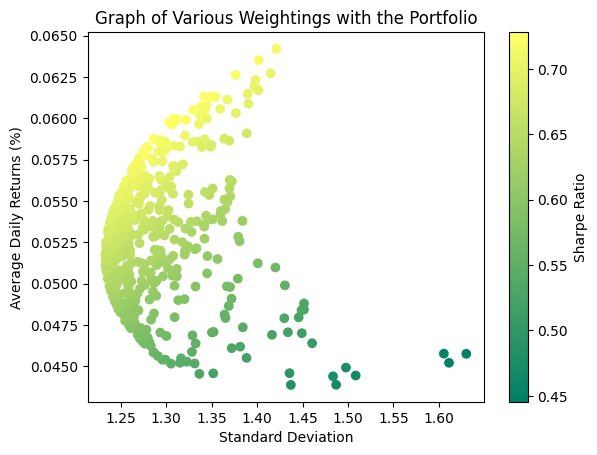

In [67]:
simulation_results, simulation_weights, min_risk, max_risk = simulateRandom(500, close_prices)
plotSimulation(simulation_results)

If all goes well, the random tests should be bounded by a discernable line. All of the portfolios on this line represent the most efficient portfolio; in other words, they represent the portfolio with the highest return for roughly the same amount of risk. The portfolio we choose should line up on that line. We can then find the weightings by looping through our results list and finding the portfolio that matches our needs. 

However, this process is slow and unexact. Thankfully, the line, also known as the efficient frontier, that bounds the portfolios has a few special properties. Modern Portfolio Theory argues that its shape is convex, and there has been a lot of mathematical research on optimizing convex problems. We can then use the pyportfolioopt library, which gives us tools to analyze this line.

# Implementation with the Pyportfolioopt Library
To have a bit more speed and accuracy in calculating the optimal portfolio, we will be using the Pyportfolioopt library (https://pyportfolioopt.readthedocs.io/en/latest/). This library implements portfolio optimization techniques, including Markowitz. This model is effective because as we have discovered, the efficient frontier can be modeled as a convex optimization problem. 

The general outline is that we create an ```EfficientFrontier``` class from the pyportfolioopt library, give it the expected returns of the various securities and their covariance with each other, and we input the risk that we want. Then, it will solve the optimization problem. Since we do want more returns as we are trying to aim for the market beat strategy, we have made the decision to increase our risk tolerance in exchange for more returns. 

## Determining Expected Returns
The first challenge is finding a way to determine expected returns. We could use the average historical prices, but that is under the assumption that future returns will replicate previous returns. We have decided to try out the Capital Asset Pricing Model as it avoids this assumption and may be more accurate. More specifically, CAPM states that the expected return of a security can be estimated with the following formula (https://www.investopedia.com/terms/c/capm.asp#toc-capital-asset-pricing-model-capm-formula):

$$R_i = R_f + \beta(R_m - R_f)$$
Where $R_i$ denotes the expected return of the individual security, $R_f$ is the risk-free rate, and $R_m$ is the return of the market. In other words, $R_m - R_f$ is the risk premium of the Market. The idea is that the covariance with the market is a better predictor of returns than the mean historical return.

To implement CAPM, we first define the risk-free rate as $(3.31\% + 4.41\%)/2 = 3.86\%$. This is the average of the Canadian 10-year benchmark bond rate (https://www.bankofcanada.ca/rates/interest-rates/lookup-bond-yields/) and the US 10-year bond rate (https://www.bloomberg.com/markets/rates-bonds/government-bonds/us). 

The following code first gets some market data, and then finds the beta of the securities in the stocks we choose. 

In [68]:
# Get market data
market_data = markowitz.getClosePrices(start_date, end_date, ["^GSPC"], start_date)  # I could not find the ticker for the TSX60
# It should be "TX60.TS"?
display(market_data.head())

# -- Now, we find the beta -- #
# Get stock data
stocks = markowitz.getClosePrices(start_date, end_date, valid_stocks[1:18], start_date)  # Replace WITH EXISTING STOCK DATA
beta_df = pd.concat([stocks, market_data], axis=1)
beta_df.dropna(axis=0, inplace=True)
# Find percent movement
beta_df_pct = jason.convertToPct(beta_df)
# Find covariance
market_cov = beta_df_pct.cov()["^GSPC"]
# Find market variance
market_var = beta_df_pct["^GSPC"].var()
# Find betas = cov/var
betas = market_cov / market_var
display(betas)

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2012-11-09,1379.849976
2012-11-12,1380.030029
2012-11-13,1374.530029
2012-11-14,1355.489990
2012-11-15,1353.329956


[*********************100%***********************]  17 of 17 completed


Ticker
ABT      0.853635
ACN      1.060460
AIG      1.168275
AMZN     1.168092
AXP      1.200895
BA       1.326763
BAC      1.238142
BB.TO    1.116872
BIIB     0.949278
BK       1.041967
BLK      1.261607
BMY      0.605332
C        1.318134
CAT      1.056091
CL       0.551660
KO       0.594606
LLY      0.705659
^GSPC    1.000000
Name: ^GSPC, dtype: float64

Now, we want to find the CAPM for each stock. The following code first finds the market return as an average of market data. We will actually be using an exponentially weighted mean. This method allows more recent data to be weighted more heavily, since it makes sense that more recent data would be related to future data. 

To calculate exponentially weighted mean, we use the following formula:

$$a_t = \frac{c_t + c_{t-1}(1-\alpha) + c_{t-2}(1-\alpha)^2 + ... + c_0(1-\alpha)^t}{1 + (1-\alpha) + (1-\alpha)^2 + ... + (1-\alpha)^t}$$
Where $t$ is the amount of periods, $c_i$ is the percent change at time $= i$, and $\alpha$ is a factor between $0$ and $1$ that will determine how weighted previous periods are weighted. 

This is the code, which uses the pandas library.

In [87]:
market_data_pct = jason.convertToPct(market_data)
market_data_pct.index = pd.to_datetime(market_data_pct.index)
resampled = market_data_pct.resample("M").ffill()
market_return = resampled.ewm(alpha=0.8, adjust=True).mean()["^GSPC"].iloc[-1]  # We want the last value
print("Market Return (month):", market_return)  # Remember that this is a percent, not a decimal

Market Return (month): 0.024670288286609665


We can now find the expected returns using the CAPM.

In [98]:
risk_free = 3.86
returns = risk_free/12 + betas[:-1]  * (market_return - risk_free/12) # The risk free rate is for a year, so we divide by 12
display(returns) 

Ticker
ABT      0.068140
ACN      0.006714
AIG     -0.025307
AMZN    -0.025252
AXP     -0.034995
BA      -0.072377
BAC     -0.046057
BB.TO   -0.010040
BIIB     0.039734
BK       0.012206
BLK     -0.053026
BMY      0.141885
C       -0.069814
CAT      0.008012
CL       0.157826
KO       0.145071
LLY      0.112088
Name: ^GSPC, dtype: float64

We now have enough information to use the pyportfolioopt library. The following code file will return the Efficient Frontier object, which we will call multiple times to get various numbers. pyportfolioopt uses a covariance matrix to determine risk, which we will store with the variable cov_matrix.

In [99]:
def optimizedEF(returns: pd.Series, risk: pd.DataFrame, min_weight: float = 0, max_weight: float = 0.15):
    # This will return the efficient frontier (i.e. most return for different amount of risk)

    # Because there's limits, we have to incorporate them
    EF = EfficientFrontier(returns, risk, weight_bounds=(min_weight, max_weight))
    return EF

cov_matrix = jason.convertToPct(stocks).cov()
display(cov_matrix.iloc[:5, :5])

Ticker,ABT,ACN,AIG,AMZN,AXP
Ticker,,,,,
ABT,2.010777,1.089751,0.924264,0.995540,1.026780
ACN,1.089751,2.218058,1.370991,1.353518,1.400320
AIG,0.924264,1.370991,3.666404,1.014601,2.322494
AMZN,0.995540,1.353518,1.014601,4.054850,1.171040
AXP,1.026780,1.400320,2.322494,1.171040,3.302008


Then, we can use this to solve for various portfolios. Our hypothesis is that to get a portfolio that beats the market, we have to accept more risk, even more than the optimal Sharpe ratio accounts for. To do so, we can get the risk for the optimal sharpe ratio . Then, we can use a ratio to choose a risk value that best meets our needs, i.e. create a target risk that is higher than the risk to create the optimal sharpe ratio portfolio. The ratio that we are using is gained through our own testing.  

In [104]:
min_weight = 1 / (2 * len(stocks.columns))  # Find the minimum weight bound

# Find sharpe ratio portfolio
sharpe_ef = optimizedEF(returns, cov_matrix, min_weight)
sharpe_weights = sharpe_ef.max_sharpe(risk_free/100)
sharpe_risk = sharpe_ef.portfolio_performance(risk_free_rate=risk_free/100)[1]

# Find target risk
target_risk = sharpe_risk * 1.1
target_ef = optimizedEF(returns, cov_matrix, min_weight)
target_weights = target_ef.efficient_risk(target_risk)
show_weights = target_ef.clean_weights()
target_performance = target_ef.portfolio_performance(risk_free_rate=risk_free/100)

# Display results
print(show_weights)

OrderedDict([('ABT', 0.04706), ('ACN', 0.02941), ('AIG', 0.02941), ('AMZN', 0.02941), ('AXP', 0.02941), ('BA', 0.02941), ('BAC', 0.02941), ('BB.TO', 0.02941), ('BIIB', 0.02941), ('BK', 0.02941), ('BLK', 0.02941), ('BMY', 0.15), ('C', 0.02941), ('CAT', 0.02941), ('CL', 0.15), ('KO', 0.15), ('LLY', 0.15)])


# References
Ivanyuk, V., & Berzin, D. (2020). *An Algorithm for Constructing an Efficient Investment Portfolio*. In Advances in Intelligent 

&ensp; Systems and Computing (pp. 482–490). Springer International Publishing. https://doi.org/10.1007/978-3-030-63322-6_39
